# refine FOV to exvivo registration and save the matching cells coordinates
- requires napari to refine registration and selecting the dots to save.

In [2]:

from datetime import date
import tifffile, pickle, napari, pprint
import sys, glob
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
import scipy.ndimage as ndi

from datetime import date
today = date.today()
todaystamp = today.strftime("%m%d%y")
print(todaystamp)
sys.path.append('./functions/')
import transformations

070924


# load exvivo 

In [3]:
datadir= '/path_to_the_data/'
exvivo_f = datadir + 'exvivo_2xds.pkl'
exvivo = pickle.load(open(exvivo_f,'rb'))[:,::-1]  #144um, because each z is 1.5 um!
exvivo[exvivo<=0]=0
print(exvivo.shape)  # channels are BV/tomatos

(2, 48, 1517, 1618)


In [4]:
Z = exvivo.shape[1]

# also load transformed invivo as the reference 
- note here we are loading the output from the transformed result from `invivo_to_exvivo` notebook

In [10]:
base_dir='/set_your_output_directory/'  # note this is also where the output will be stored!
invivo_t = pickle.load(open(base_dir + f'transformed_06202024.pkl','rb'))['transformed'][:Z]
# invivo_t = pickle.load(open('/Users/shuonan/Downloads/invivo_tomato_T_2xds.pkl', 'rb'))[:Z]

In [11]:
invivo_t.shape

(48, 1517, 1618)

# load ONE fov

In [12]:
transformedFOV_path = "/Users/shuonan/Downloads/transformed_FOVs/"
glob.glob(transformedFOV_path+"*")

['/Users/shuonan/Downloads/transformed_FOVs/FOV_Stacked_ch2_movie_FOV13_14_zstack_1100nm_3x_.tif_mapped_to_exvivo_2xds.pkl',
 '/Users/shuonan/Downloads/transformed_FOVs/FOV_Stacked_ch2_movie_FOV9_zstack_1100nm_3x_.tif_mapped_to_exvivo_2xds.pkl',
 '/Users/shuonan/Downloads/transformed_FOVs/FOV_Stacked_ch2_movie_FOV3_4_zstack_1100nm_3x_.tif_mapped_to_exvivo_2xds.pkl',
 '/Users/shuonan/Downloads/transformed_FOVs/FOV_Stacked_ch2_movie_FOV11_12_zstack_1100nm_3x_.tif_mapped_to_exvivo_2xds.pkl',
 '/Users/shuonan/Downloads/transformed_FOVs/FOV_Stacked_ch2_movie_FOV10_zstack_1100nm_3x.tif_mapped_to_exvivo_2xds.pkl',
 '/Users/shuonan/Downloads/transformed_FOVs/FOV_Stacked_ch2_movie_FOV1_2_zstack_1100nm_3x_.tif_mapped_to_exvivo_2xds.pkl']

In [18]:
fovfile = transformedFOV_path + 'FOV_Stacked_ch2_movie_FOV11_12_zstack_1100nm_3x_.tif_mapped_to_exvivo_2xds.pkl'
mapped_fov = pickle.load(open(fovfile, 'rb'))[:Z]
print(mapped_fov.shape)

(48, 1517, 1618)


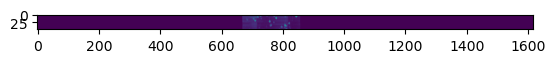

In [19]:
plt.imshow(np.max(mapped_fov,1))

In [20]:
fov_id = fovfile.split('/')[-1].split('FOV')[2].split('_zstack')[0]
print(fov_id)

11_12


# launch napari 
- note we are NOT transforming invivo layer to save time. `in_layer` is purely for the diagnosis purpose, and only be used before starting the registration. feel free to remove it if necessary. 

In [21]:
## note here the transforming ones are the fov_layers!!!
features = {'label': np.empty(0, dtype=int)}
all_transform_FOV = []

viewer = napari.view_image(exvivo[1][None],channel_axis=0,name=['EX Tomato'],
                           contrast_limits=(0,exvivo[1].max()),colormap="green", visible = [True], blending='additive')
fov_layer = viewer.add_image(mapped_fov[None],channel_axis=0,name=[f'FOV {fov_id} tomato'],
                             contrast_limits=(0,mapped_fov.max()), colormap='red',visible = [True], blending='additive')
in_layer = viewer.add_image(invivo_t[None],channel_axis=0,name=[f'invivo tomato'],
                             contrast_limits=(0,invivo_t.max()), colormap='red',visible = [True], blending='additive')


pl_in = viewer.add_points(
    size=10, edge_width=1, edge_color='red',face_color='transparent',name=f"IN points", text='label', 
    features=features,ndim=3,out_of_slice_display=True)
@pl_in.events.data.connect
def update_feature_default_invivo():  
    global points_layer
    no_of_points = len(pl_in.data)
    pl_in.feature_defaults['label'] = no_of_points + 1
    pl_in.properties["label"][0:no_of_points] = range(1, no_of_points+1)
    pl_in.text.values[0:no_of_points] = [str(i) for i in range(1, no_of_points+1)]
    pl_in.text.color = 'red'
    pl_in.text.translation = np.array([-10, 0])
update_feature_default_invivo()
pl_in.mode = 'add'

pl_ex = viewer.add_points(
    size=10, edge_width=1, edge_color='green',face_color='transparent',name=f"EX points", text='label', 
    features=features,ndim=3,out_of_slice_display=True)
@pl_ex.events.data.connect
def update_feature_default_exvivo():  
    global points_layer
    no_of_points = len(pl_ex.data)
    pl_ex.feature_defaults['label'] = no_of_points + 1
    pl_ex.properties["label"][0:no_of_points] = range(1, no_of_points+1)
    pl_ex.text.values[0:no_of_points] = [str(i) for i in range(1, no_of_points+1)]
    pl_ex.text.color = 'green'
    pl_ex.text.translation = np.array([-10, 0])
update_feature_default_exvivo()
pl_ex.mode = 'add'


@viewer.bind_key('s', overwrite = True)
def scale(viewer):  
    C = 1
    print('learning scale..')
    m_invivo = viewer.layers[f"IN points"].data
    m_exvivo = viewer.layers[f"EX points"].data
    assert len(m_invivo)==len(m_exvivo), f"{len(m_invivo), len(m_exvivo)}"
    s_invivo = np.sqrt(np.sum((m_invivo-np.mean(m_invivo,0))**2)/len(m_invivo))
    s_exvivo = np.sqrt(np.sum((m_exvivo-np.mean(m_exvivo,0))**2)/len(m_exvivo))
    scl = s_exvivo/s_invivo
    print(f'scale difference: {scl}')
    m_invivo_new = scl*m_invivo    
    fov_layer_scaled = np.array([ndi.zoom(fov_layer[c].data, scl, order=1) for c in range(C)])    
    for c in range(C):
        fov_layer[c].data = fov_layer_scaled[c]
    viewer.layers["IN points"].data = m_invivo_new    
    
    
@viewer.bind_key('t', overwrite = True)
def transform(viewer):    
    C=1
    viewer.update_console(locals())
    print('applying rigid..')
    m_invivo = viewer.layers[f"IN points"].data
    m_exvivo = viewer.layers[f"EX points"].data
    assert len(m_invivo)==len(m_exvivo), f"{len(m_invivo), len(m_exvivo)}"
    bhat = wahba(m_invivo, m_exvivo)
    offset = -(bhat[:3,:3])@bhat[-1]
    fov_layer_affined = np.array([ndi.affine_transform(fov_layer[c].data, bhat[:3,:3],
                                                    output_shape = viewer.layers['EX Tomato'].data.shape,
                                                    offset = offset, order=1) for c in range(C)])
    foo = np.c_[m_invivo, np.ones((m_invivo.shape[0],1))]   #Nx4    
    m_invivo_new = foo@bhat
    viewer.layers["IN points"].data = m_invivo_new    
    all_transform_FOV.append(dict(bhat=bhat))
    for c in range(C):
        fov_layer[c].data = fov_layer_affined[c]
    print("done transform!")

# again this is to deform in vivo points to map to exvivo points!
@viewer.bind_key('d', overwrite = True)
def deform(viewer):    
    print('applying deformable..')
    ksz = 10
    m_invivo = viewer.layers[f"IN points"].data
    m_exvivo = viewer.layers[f"EX points"].data 
    assert len(m_invivo)==len(m_exvivo), f"{len(m_invivo), len(m_exvivo)}"
    shift = m_exvivo-m_invivo   # so the newcoords = old+shift --> vecfield will have how much shift needed to apply to the old coords
    vec_field = np.zeros(fov_layer[0].data.shape + (3,))  # M1,M2,2
    for p,loc in enumerate(m_invivo):
        vec_field[int(loc[0]),int(loc[1]),int(loc[2])] = shift[p]
    for c in range(3):
        vec_field[...,c] = ndi.gaussian_filter(vec_field[...,c], ksz)
    A = np.zeros_like(m_invivo)
    for p,loc in enumerate(m_invivo):
        A[p] = vec_field[int(loc[0]),int(loc[1]),int(loc[2])]
    diag_step,_,_,_ = np.linalg.lstsq(A,shift,rcond=None)
    step = np.diag(diag_step)
    vec_field_total =vec_field*step;  # element wise. 
    all_transform_FOV.append(dict(vec_field_total=vec_field_total))
    mapz_base, mapx_base, mapy_base = np.meshgrid(np.arange(fov_layer[0].data.shape[0]),np.arange(fov_layer[0].data.shape[1]), 
                                       np.arange(fov_layer[0].data.shape[2]), indexing='ij')
    mapz=mapz_base-vec_field_total[:,:,:,0]
    mapx=mapx_base-vec_field_total[:,:,:,1]
    mapy=mapy_base-vec_field_total[:,:,:,2]
    
    for c in range(2):
        print(f'... warping for channel {c}')
        img_de = warp(fov_layer[c].data,np.array((mapz,mapx,mapy)), order = 1)            
        fov_layer[c].data = img_de    
    
    m_invivo_new = np.zeros_like(m_invivo)  # POINTS
    for p,loc in enumerate(m_invivo):
        new_s = vec_field_total[int(loc[0]),int(loc[1]),int(loc[2])]
        m_invivo_new[p] = loc+new_s
    viewer.layers["IN points"].data = m_invivo_new
    
    plt.figure(figsize = (10,3))
    for c in range(3):
        plt.subplot(1,3,c+1)
        plt.imshow(np.max(vec_field_total[...,c], 0))
        plt.colorbar()
    print('done deformation!')
    plt.show()
        
    
@viewer.bind_key('c',overwrite = True)
def clear_selected(viewer):        
    viewer.layers[f"IN points"].data = np.empty((0, 3))
    viewer.layers[f"EX points"].data = np.empty((0, 3))


@viewer.bind_key('q', overwrite = True)
def save_rez(viewer):     
    out_dict = dict()
    out_dict['transformed tomato']=viewer.layers[f'FOV {fov_id} tomato'].data.astype('float16')
    out_dict['invivo points']=viewer.layers['IN points'].data
    out_dict['exvivo points']=viewer.layers['EX points'].data
#     out_dict['transformed gcamp']=viewer.layers[f'FOV {fov_id} gcamp'].data.astype('float16')
    out_dict['transformations']=all_transform_FOV      
    
    pickle.dump(out_dict, open(base_dir + f'transformed_fov_{fov_id}_{todaystamp}.pkl','wb'))
    print(f"saved the results! ({base_dir + f'transformed_fov_{fov_id}_{todaystamp}.pkl'})")
    

learning scale..
scale difference: 0.9815037085163179
applying rigid..
done transform!
